# Repeated bolus injection with linear clearance

In this model we model the drug amount in a compartment with a linear clearance rate

\begin{equation}
    \frac{\text{d}a}{\text{d}t} = -ka + r_{\text{dose}}(t),
\end{equation}

where $a$ is the amount of drug in the compartment, $k$ is the elimination rate and $r_{\text{dose}}$ is the dose rate. This simple model reduces to a simple exponential decay, where the the bolus injections instantaneously update the amount in the compartment. The analytic solution to this problem is given by

\begin{equation}
    a(t) = a_0 \exp \left( -k t \right) + \int _0^t \text{d}t'\, r_{\text{dose}}(t') \exp \left( -k (t-t') \right).
\end{equation}

Here $a_0$ is the initial drug in the compartment. The first term represents the linear clearance of the initial drug amount, while the second term is the linear clearance of the injected drug amount at later times.

The partial derivatives of this model can be straightforwardly computed to be

\begin{equation}
    \frac{\partial a}{\partial a_0} = \exp \left( -k t \right) \quad \text{and} \quad \frac{\partial a}{\partial k} = -t\, a_0 \exp \left( -k t \right) - \int _0^t \text{d}t'\, (t-t')\, r_{\text{dose}}(t') \exp \left(- k (t-t') \right).
\end{equation}

## Build model

In [1]:
import myokit

model = myokit.Model()
comp = model.add_component('myokit')

# Add state, parameters and time and pace bound variables
amount = comp.add_variable('amount')
time = comp.add_variable('time')
dose_rate = comp.add_variable('dose_rate')
elimination_rate = comp.add_variable('elimination_rate')

# Bound variables
time.set_binding('time')
dose_rate.set_binding('pace')

# Assign rhs
amount.promote(10)
amount.set_rhs(
    myokit.Minus(
        myokit.Name(dose_rate),
        myokit.Multiply(
            myokit.Name(elimination_rate),
            myokit.Name(amount))))
elimination_rate.set_rhs(myokit.Number(1))
time.set_rhs(myokit.Number(0))
dose_rate.set_rhs(myokit.Number(0))

print(model.code())

[[model]]
# Initial values
myokit.amount = 10

[myokit]
dot(amount) = dose_rate - elimination_rate * amount
dose_rate = 0 bind pace
elimination_rate = 1
time = 0 bind time




## Solve model with Myokit

[<InitialValue(<Name(<State(myokit.amount)>)>)>, <Name(<Var(myokit.elimination_rate)>)>]








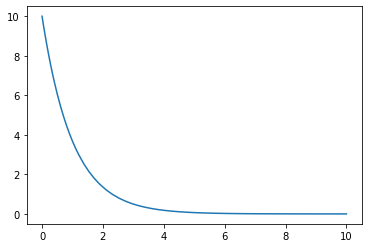

In [5]:
import matplotlib.pyplot as plt
import numpy as np

sensitivities = (
    ['myokit.amount'],
    ['init(myokit.amount)', 'myokit.elimination_rate'])
sim = myokit.Simulation(model, None, sensitivities)

solution, partials = sim.run(10)

# Plot results
plt.figure()
plt.plot(solution.time(), solution['myokit.amount'])
plt.show()

In [ ]:
partials

## Solve model with the analytical solution

For a bolus dosing schedule that administered an instantaneous dose at each time unit of amount d, the time dependent dose rate can be expressed by a sum of delta functions

\begin{equation}
    r_{\text{dose}}(t) = d\sum _{i=0}^{\infty} \delta (t - i).
\end{equation}

As a result, the analytical solution takes the form

\begin{equation}
    a(t) = a_0 \exp \left( -k t \right) + d\sum _{i=0}^{n(t)} \exp \left( -k (t-i) \right) = a_0 \exp \left( -k t \right) + d \exp \left( -kt \right) \frac{\exp \left( k(n(t)+1)\right) - 1}{\exp \left( k\right) - 1} = a_0 \textrm{e} ^{ -k t } + a_{\infty}^{\text{max}} \left[ \textrm{e} ^{ -k\Delta t _{\text{last}} } - \textrm{e} ^{ -k(t+1) } \right],
\end{equation}

with partials

\begin{equation}
    \frac{\partial a}{\partial a_0} = \exp \left( -k t \right) \quad \text{and} \quad \frac{\partial a}{\partial k} = -ta_0 \textrm{e} ^{ -k t } - a_{\infty}^{\text{max}} \left[ \Delta t _{\text{last}}\textrm{e} ^{ -k\Delta t _{\text{last}} } - (t+1)\textrm{e} ^{ -k(t+1) } \right] - a_{\infty}^{\text{max}}\frac{\textrm{e} ^{ -k}}{1-\textrm{e} ^{ -k}} \left[ \textrm{e} ^{ -k\Delta t _{\text{last}} } - \textrm{e} ^{ -k(t+1) } \right].
\end{equation}

Here, $n(t) = \left\lfloor t \right\rfloor$ is the largest integer smaller $t$ (the floor of $t$), $a_{\infty}^{\text{max}} = d / (1 - \textrm{e} ^{ -k})$ is the limiting maximum amount of the drug in the compartment for large times and $\Delta t _{\text{last}} = t - n(t)$ is the time since the last dose.

In [20]:
import numpy as np

def solve_amount(parameters, times):
    """
    Returns the amount of the drug using the analytical solution.
    """
    times = np.asarray(times)

    # Unpack parameters
    a_0, elimination_rate, dose = parameters

    # Compute time since last dose
    delta_times = times - np.floor(times)

    # Compute a max
    a_max = dose / (1 - np.exp(-elimination_rate))

    # Compute amount
    amount = \
        a_0 * np.exp(-elimination_rate * times) + \
        a_max * (np.exp(-elimination_rate * delta_times) - np.exp(-elimination_rate * (times + 1)))

    return amount

def solve_partials(parameters, times):
    """
    Returns the partial derivatives of the amount with respect to the initial amount and the elimination rate.

    Returns:
        [partials w.r.t. initial amount, partials w.r.t. elimination rate]
    """
    times = np.asarray(times)

    # Unpack parameters
    a_0, elimination_rate, dose = parameters

    # Compute time since last dose
    delta_times = times - np.floor(times)

    # Compute a max
    a_max = dose / (1 - np.exp(-elimination_rate))

    # Compute partials
    damount_dinitial_amount = np.exp(-elimination_rate * times)
    damount_delimination_rate = \
        -times * a_0 * np.exp(-elimination_rate * times) - \
        a_max * (delta_times * np.exp(-elimination_rate * delta_times) - (times + 1) * np.exp(-elimination_rate * (times + 1))) - \
        a_max * (np.exp(-elimination_rate * delta_times) - np.exp(-elimination_rate * (times + 1))) * np.exp(-elimination_rate) / (1 - np.exp(-elimination_rate))

    return np.vstack([damount_dinitial_amount, damount_delimination_rate])

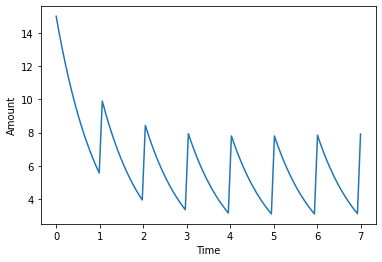

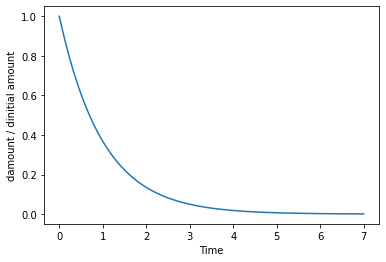

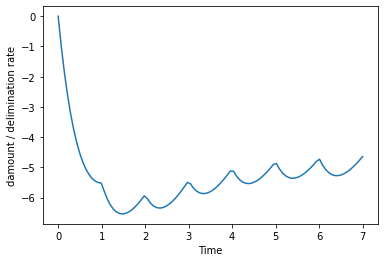

In [23]:
import matplotlib.pyplot as plt

times = np.linspace(0, 7, 100)
parameters = [10, 1, 5]
solution = solve_amount(parameters, times)
partials = solve_partials(parameters, times)

# Plot results
plt.figure()
plt.plot(times, solution)
plt.xlabel('Time')
plt.ylabel('Amount')
plt.show()

plt.figure()
plt.plot(times, partials[0, :])
plt.xlabel('Time')
plt.ylabel('damount / dinitial amount')
plt.show()

plt.figure()
plt.plot(times, partials[1, :])
plt.xlabel('Time')
plt.ylabel('damount / delimination rate')
plt.show()